# The Impact of Cultural Participation on National Innovation
**Abstract:** This study explores the link between cultural engagement and innovation performance across 32 European nations. By integrating Eurostat cultural data with the European Innovation Scoreboard (2022-2025), it evaluates if cultural participation meaningfully contributes to economic innovation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

1. Data Import

In [2]:
# Eurostat cultural participation data (2022)
culture_path = "/content/ilc_scp03$dv_550_page_spreadsheet.xlsx"
# European Innovation Scoreboard data
eis_path = "/content/EIS_web_download.xlsx"

culture_raw = pd.read_excel(culture_path)
eis_raw = pd.read_excel(eis_path)

# Inspect the structure
culture_raw.head(), eis_raw.head()

(                              ACL00 (Labels)  \
 0                               GEO (Labels)   
 1  European Union - 27 countries (from 2020)   
 2                                    Belgium   
 3                                   Bulgaria   
 4                                    Czechia   
 
   Cultural activities (cinema, live performances or cultural sites)  
 0                                                NaN                 
 1                                                  :                 
 2                                               76.3                 
 3                                               38.3                 
 4                                               78.3                 ,
   iso2  country   group  year indicator_code  \
 0   AL  Albania  non-eu  2018            SII   
 1   AL  Albania  non-eu  2018          1.1.1   
 2   AL  Albania  non-eu  2018          1.1.2   
 3   AL  Albania  non-eu  2018          1.1.3   
 4   AL  Albania  non-eu  2018  

2. Cleaning cultural participation data

In [3]:
culture = culture_raw.copy()

# Standardise column names
culture.columns = culture.columns.str.lower()

# Drop useless rows
culture = culture.drop(index=[0])
culture.head()

,acl00 (labels),"cultural activities (cinema, live performances or cultural sites)"
1,European Union - 27 countries (from 2020),:
2,Belgium,76.3
3,Bulgaria,38.3
4,Czechia,78.3
5,Denmark,86.1


In [4]:
# Rename key columns (adjust if naming differs slightly)
culture = culture.rename(columns={
    "acl00 (labels)": "country",
    "cultural activities (cinema, live performances or cultural sites)": "participation_rate"
})

indices_to_drop = culture[culture["participation_rate"] == ":"].index

# Drop the identified rows
culture.drop(indices_to_drop, inplace=True)

culture["participation_rate"] = pd.to_numeric(
    culture["participation_rate"],
    errors="coerce"
)

print(culture)

        country  participation_rate
2       Belgium                76.3
3      Bulgaria                38.3
4       Czechia                78.3
5       Denmark                86.1
7       Estonia                82.7
8       Ireland                80.2
9        Greece                65.6
10        Spain                80.4
11       France                75.7
12      Croatia                69.4
13        Italy                64.0
14       Cyprus                53.7
15       Latvia                57.6
16    Lithuania                72.1
17   Luxembourg                89.0
18      Hungary                63.2
19        Malta                61.9
20  Netherlands                86.9
21      Austria                79.0
22       Poland                76.8
23     Portugal                81.2
24      Romania                41.9
25     Slovenia                72.1
26     Slovakia                61.1
27      Finland                78.9
28       Sweden                76.9
30       Norway             

3. Cleaning European Innovation Scoreboard data

In [5]:
eis = eis_raw.copy()
# Standardise column names
eis.columns = eis.columns.str.lower()

# The EIS contains many indicators, retain only the headline index
eis_sii = eis[
    eis["indicator"].str.contains("Summary Innovation Index", case=False, na=False)
]
eis_sii.head()

,iso2,country,group,year,indicator_code,indicator,value,performance group
0,AL,Albania,non-eu,2018,SII,Summary Innovation Index,35.256689,Emerging
26,AT,Austria,eu,2018,SII,Summary Innovation Index,120.118456,Strong
59,BA,Bosnia & Herzegovina,non-eu,2018,SII,Summary Innovation Index,22.858167,Emerging
86,BE,Belgium,eu,2018,SII,Summary Innovation Index,126.380213,Leader
119,BG,Bulgaria,eu,2018,SII,Summary Innovation Index,45.240224,Emerging


In [6]:
# Pivot to obtain country–year values
eis_sii_pivot = (
    eis_sii
    .pivot_table(
        index=["country", "year"],
        values="value",
        aggfunc="mean"
    )
    .reset_index()
)
# Rename and clean
eis_sii_pivot = eis_sii_pivot.rename(
    columns={"value": "innovation_score"}
)
eis_sii_pivot["innovation_score"] = pd.to_numeric(
    eis_sii_pivot["innovation_score"], errors="coerce"
)
eis_sii_pivot.head()

,country,year,innovation_score
0,Albania,2018,35.256689
1,Albania,2019,36.549373
2,Albania,2020,35.503238
3,Albania,2021,38.166049
4,Albania,2022,40.624234


In [7]:
# Keep recent years (2022–2025)
eis_sii_pivot = eis_sii_pivot[
    eis_sii_pivot["year"].between(2022, 2025)
]
eis_sii_pivot.tail(10)

,country,year,innovation_score
302,Turkey,2024,62.591789
303,Turkey,2025,65.335466
308,Ukraine,2022,33.306270
309,Ukraine,2023,32.870553
310,Ukraine,2024,33.933698
311,Ukraine,2025,32.640142
316,United Kingdom,2022,140.067584
317,United Kingdom,2023,139.616973
318,United Kingdom,2024,140.148381
319,United Kingdom,2025,141.356455


In [8]:
# Replace 'Turkey' with 'Türkiye' in the country column
eis_sii_pivot["country"] = eis_sii_pivot["country"].replace("Turkey", "Türkiye")
eis_sii_pivot.tail(10)

,country,year,innovation_score
302,Türkiye,2024,62.591789
303,Türkiye,2025,65.335466
308,Ukraine,2022,33.306270
309,Ukraine,2023,32.870553
310,Ukraine,2024,33.933698
311,Ukraine,2025,32.640142
316,United Kingdom,2022,140.067584
317,United Kingdom,2023,139.616973
318,United Kingdom,2024,140.148381
319,United Kingdom,2025,141.356455


4. Merging datasets

In [9]:
# Merge cultural participation with innovation scores
data = eis_sii_pivot.merge(
    culture,
    on="country",
    how="inner"
)

# Drop missing observations
data = data.dropna(subset=["innovation_score", "participation_rate"])
print(data)

         country  year  innovation_score  participation_rate
0        Albania  2022         40.624234                48.3
1        Albania  2023         39.239770                48.3
2        Albania  2024         38.267340                48.3
3        Albania  2025         42.658124                48.3
4        Austria  2022        128.971362                79.0
..           ...   ...               ...                 ...
123  Switzerland  2025        157.374400                88.9
124      Türkiye  2022         58.234700                35.9
125      Türkiye  2023         61.538428                35.9
126      Türkiye  2024         62.591789                35.9
127      Türkiye  2025         65.335466                35.9

[128 rows x 4 columns]


 5. Descriptive statistics

In [10]:
desc_stats = data[[
    "participation_rate",
    "innovation_score"
]].describe()

print(desc_stats)

       participation_rate  innovation_score
count          128.000000        128.000000
mean            69.309375         99.972548
std             15.043755         35.783121
min             35.900000         37.894093
25%             61.700000         70.339842
50%             73.900000        100.134520
75%             80.250000        132.012515
max             89.000000        164.204927


6. Exploratory visualisation

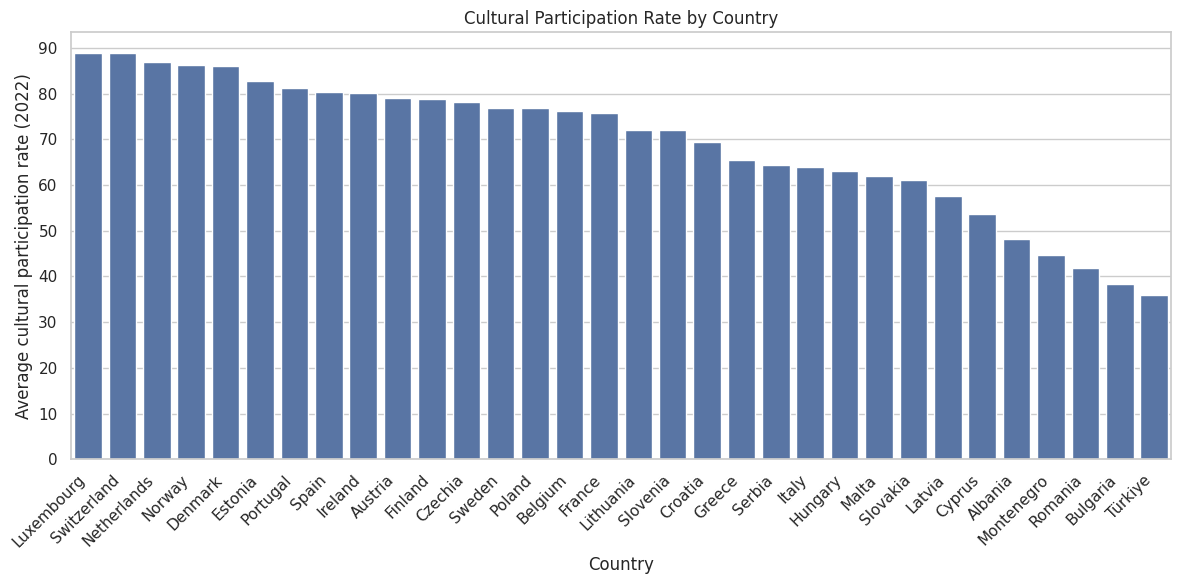

In [11]:
# 1. Cultural Participation Rate by Country
# Sort data by participation rate for a cleaner distribution look
data_sorted = data.sort_values("participation_rate", ascending=False)

# Set the visual style
sns.set_theme(style="whitegrid")

# Create the Country-wise Distribution Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=data_sorted,
    x="country",
    y="participation_rate"
)
# Set y-axis ticks at intervals of 10
plt.yticks(range(0, 100, 10))

# Formatting
plt.xticks(rotation=45, ha='right') # Rotates country names for readability
plt.xlabel("Country")
plt.ylabel("Average cultural participation rate (2022)")
plt.title("Cultural Participation Rate by Country")

plt.tight_layout()
plt.show()

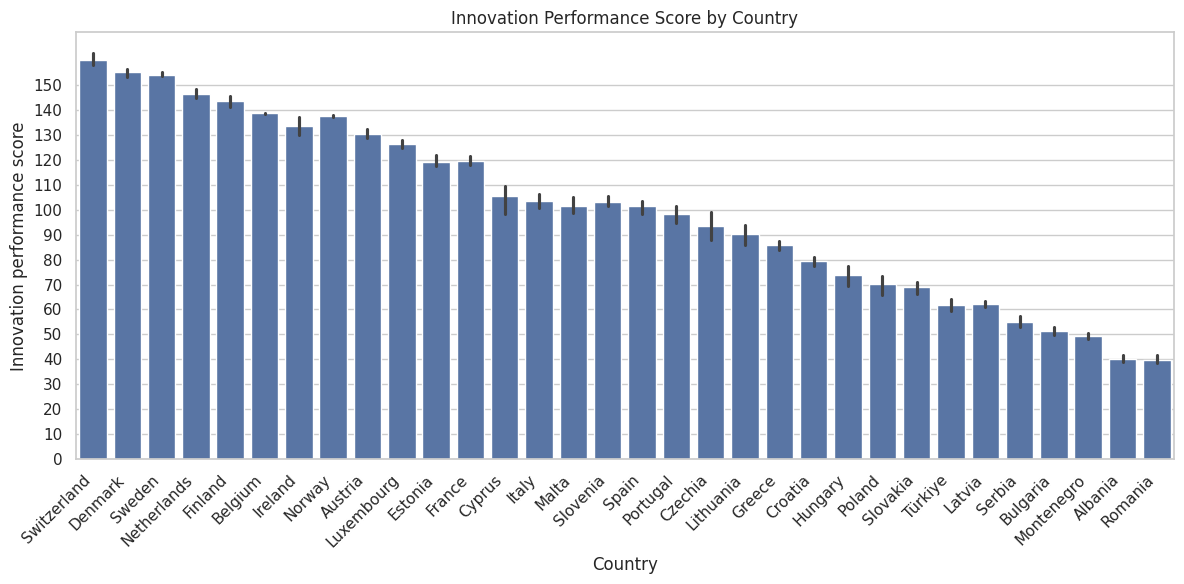

In [12]:
# 2. Innovation Performance Score by Country
# Sort data by innovation score for a cleaner distribution look
data_sorted = data.sort_values("innovation_score", ascending=False)

# Set the visual style
sns.set_theme(style="whitegrid")

# Create the Country-wise Distribution Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=data_sorted,
    x="country",
    y="innovation_score"
)

# Set y-axis ticks at intervals of 10
plt.yticks(range(0, 160, 10))

# Formatting
plt.xticks(rotation=45, ha='right') # Rotates country names for readability
plt.xlabel("Country")
plt.ylabel("Innovation performance score")
plt.title("Innovation Performance Score by Country")

plt.tight_layout()
plt.show()

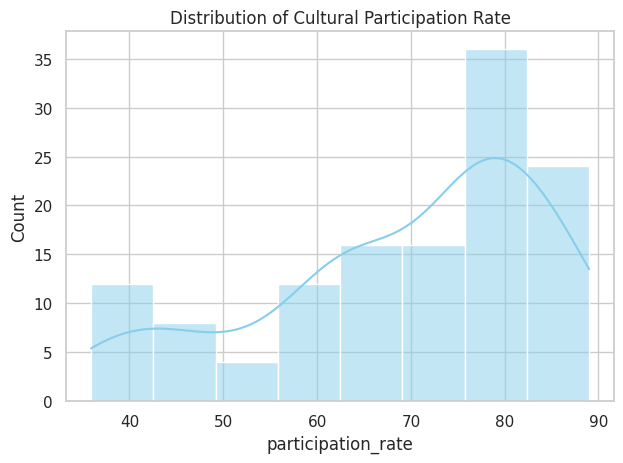

In [13]:
# 3. Distribution of Cultural Participation Rate
sns.histplot(data=data, x="participation_rate", kde=True, color="skyblue")
plt.title("Distribution of Cultural Participation Rate")
plt.tight_layout()
plt.show()

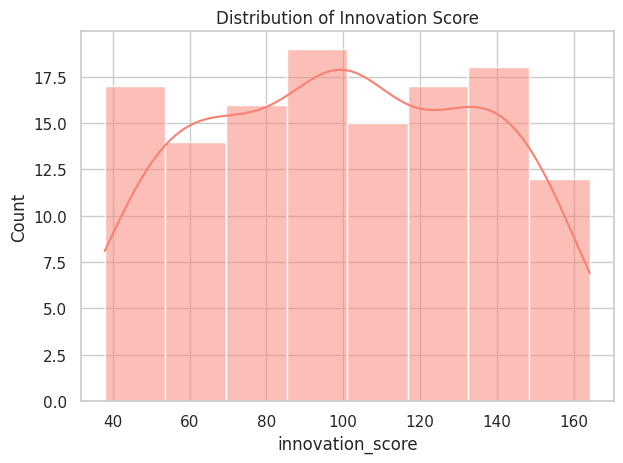

In [14]:
# 4. Distribution of Innovation Score
sns.histplot(data=data, x="innovation_score", kde=True, color="salmon")
plt.title("Distribution of Innovation Score")
plt.tight_layout()
plt.show()

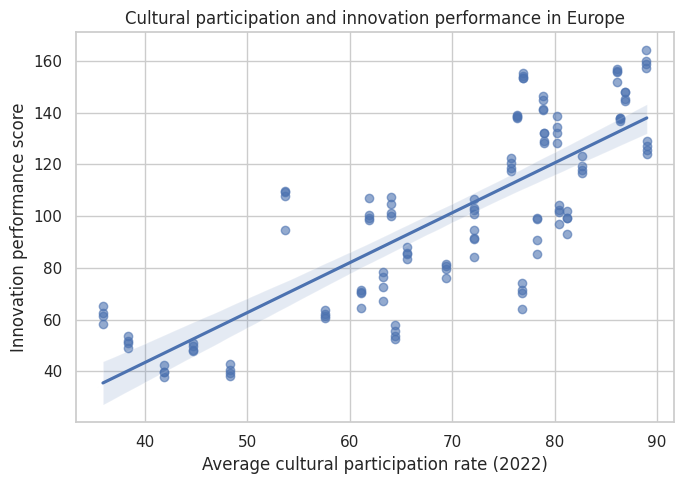

In [15]:
# 5. Regression Plot
plt.figure(figsize=(7,5))
sns.regplot(
    data=data,
    x="participation_rate",
    y="innovation_score",
    scatter_kws={"alpha": 0.6}
)
plt.xlabel("Average cultural participation rate (2022)")
plt.ylabel("Innovation performance score")
plt.title("Cultural participation and innovation performance in Europe")
plt.tight_layout()
plt.show()

7. Correlation analysis

In [16]:
# Compute Pearson correlation between cultural participation and innovation performance
corr = data[["participation_rate", "innovation_score"]].corr()
print(corr)

                    participation_rate  innovation_score
participation_rate            1.000000          0.811169
innovation_score              0.811169          1.000000


8. Predective modeling

In [17]:
X = data[["participation_rate"]]
y = data["innovation_score"]

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [19]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

print("Linear regression R²:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear regression R²: 0.7507173002052723
RMSE: 17.96811429620681


In [20]:
# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random forest R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random forest R²: 0.980006897698474
RMSE: 5.088579052999386
